In [206]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import glob
import scipy.signal as scs

In [2]:
def avantes_aggregator(filepath,fileout):
    """ Aggregates Avantes ASCII 2D spectra takes the log folder (avantes generated) and the name
    (with path) of the output npy """
    files = glob.glob(filepath+'*.TXT')
    #print(files)
    for ii,filename in enumerate(files):
        counts = []
        if ii==0:
            wavelength = []
            with open(filename) as file:
                lineas=file.readlines()
                lineas=lineas[8:-2]
            for line in lineas:
                lines=line.split(';')
                wavelength.append(float(lines[0]))
                counts.append(float(lines[1]))
            spectra=np.concatenate((np.array(wavelength,ndmin=2).T,np.array(counts,ndmin=2).T),axis=1)
        else:
            with open(filename) as file:
                lineas=file.readlines()
                lineas=lineas[8:-2]
            for line in lineas:
                lines=line.split(';')
                counts.append(float(lines[1]))
            spectra=np.concatenate((spectra,np.array(counts,ndmin=2).T),axis=1)
    np.save(fileout,spectra)

def spectra_accumulator(npyin,samples,verbose=0):
    """ Accumulates a number of samples from the single spectrum npy matrix """
    ceaspec = np.load(npyin)
    cols=len(ceaspec[0,:])

    fromcol = 1
    tocol = fromcol + samples
    accum=np.copy(ceaspec[:,0]).reshape(len(ceaspec[:,0]),1)

    while tocol<=cols:
        #print(fromcol,tocol)
        suma=np.sum(ceaspec[:,fromcol:tocol],axis=1,keepdims=1)
        accum=np.concatenate((accum,suma),axis=1)
        tocol=tocol+samples
        fromcol=fromcol+samples
    if verbose==1:
        print(accum.shape)
    return accum

def extinction(I_sample, I_0, Reff, distance):
    "Calculates extinction spectrum"
    I_ratio=(I_0/I_sample)
    return (1/distance)*(I_ratio-1)*(1-Reff)

In [3]:
##### Spectra handling

In [5]:
## Load files into matrices
logfolder1 = 'D:\\CCA\\Avantes\\logs10dic\\'
#logfolder1 = '/home/mixtli/Avantes/logs30nov/'
#DCbg1=np.load(logfolder1 + 'CEASbckg1DC.npy')
#DCbg2=np.load(logfolder1 + 'CEASbckg2DC.npy')
#DCln1=np.load(logfolder1 + 'CEASline1DC.npy')

SCbg1a = spectra_accumulator(logfolder1 + 'CEASbckg1aSC.npy',20)
SCbg1 = spectra_accumulator(logfolder1 + 'CEASbckg1SC.npy',20)
SCbg2 = spectra_accumulator(logfolder1 + 'CEASbckg2SC.npy',20)
SCln1 = spectra_accumulator(logfolder1 + 'CEASline1SC.npy',20)

In [308]:
## Extinction
line=SCln1
bckg=SCbg2
I_sample=np.average(line[:,1:],axis=1)
I_0=np.average(bckg[:,1:],axis=1)
alpha1 = extinction(I_sample,I_0,0.9994,70)-f_c_sg*(1-0.9994)

line=SCln1
bckg=SCbg1
I_sample=np.average(line[:,1:],axis=1)
I_0=np.average(bckg[:,1:],axis=1)
alpha2 = extinction(I_sample,I_0,0.9994,70)-f_c_sg*(1-0.9994)

In [396]:
NO2ref=np.load("NO2ref_AvSC_corr.npy")

line=SCln1
bckg=SCbg2

I_sample=np.average(line[:,1:],axis=1)
I_0=np.average(bckg[:,1:],axis=1)
I_ratio=I_0/I_sample
d=70

Reff = 1-(((NO2ref[:,1]*7.5e11)*d)/(I_ratio-1))

(0.99994, 1.00001)

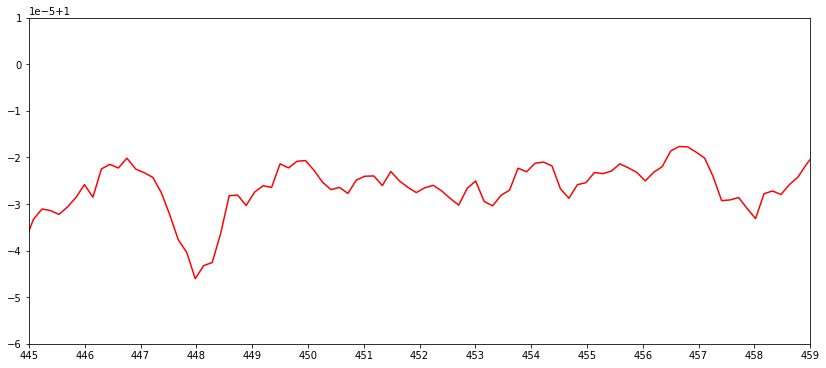

In [318]:
f, ax1 = plt.subplots(figsize=(14,6))

#ax1.plot(SCln1[:,0]*.95+22.95, alpha2,'-g',label="Ext")
ax1.plot(line[:,0]*.95+22.95, Reff,'-r',label="")

ax1.set_xlim(445,459)
ax1.set_xticks(np.arange(445,460,1))
ax1.set_ylim(.99994,1.00001)
#ax1.set_xticks(np.arange(440,466,2))
#ax1.set_xlabel('Wavelength',size=14)
#ax1.set_ylabel('Extinction (cm$^{-1}$)',size=14)
#ax1.set_title("CEAS: Extinction v. NO2 reference",size=16)
#ax1.legend(fontsize=12, loc='upper left')
#ax1.tick_params(labelsize=12)
#props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
#ax1.text(0.05, 0.95, 'N=9E10 molecule*$cm^{-3}$ (~4ppb)\n c=5.15E-7', transform=ax0.transAxes, fontsize=14,verticalalignment='top', bbox=props)
#plt.savefig('BBCEASext_v_ref.png')

(1.8, 2.0)

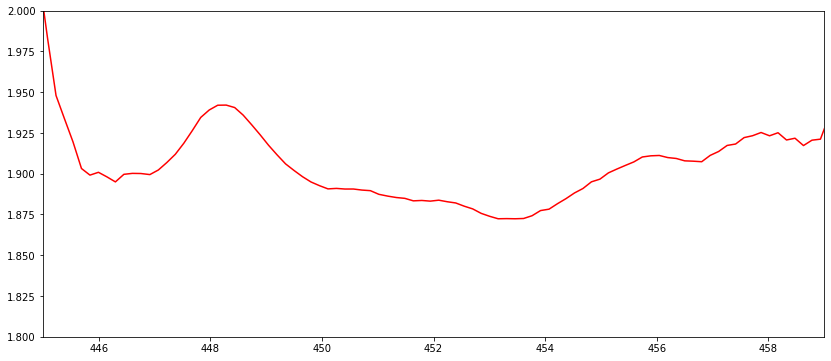

In [326]:
f, ax1 = plt.subplots(figsize=(14,6))

#ax1.plot(SCln1[:,0]*.95+22.95, alpha2,'-g',label="Ext")
ax1.plot(line[:,0]*.95+22.95, I_ratio,'-r',label="")

ax1.set_xlim(445,459)
#ax1.set_xticks(np.arange(445,460,1))
ax1.set_ylim(1.80,2)
#ax1.set_xticks(np.arange(440,466,2))
#ax1.set_xlabel('Wavelength',size=14)
#ax1.set_ylabel('Extinction (cm$^{-1}$)',size=14)
#ax1.set_title("CEAS: Extinction v. NO2 reference",size=16)
#ax1.legend(fontsize=12, loc='upper left')
#ax1.tick_params(labelsize=12)
#props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
#ax1.text(0.05, 0.95, 'N=9E10 molecule*$cm^{-3}$ (~4ppb)\n c=5.15E-7', transform=ax0.transAxes, fontsize=14,verticalalignment='top', bbox=props)
#plt.savefig('BBCEASext_v_ref.png')

(0.0115, 0.0135)

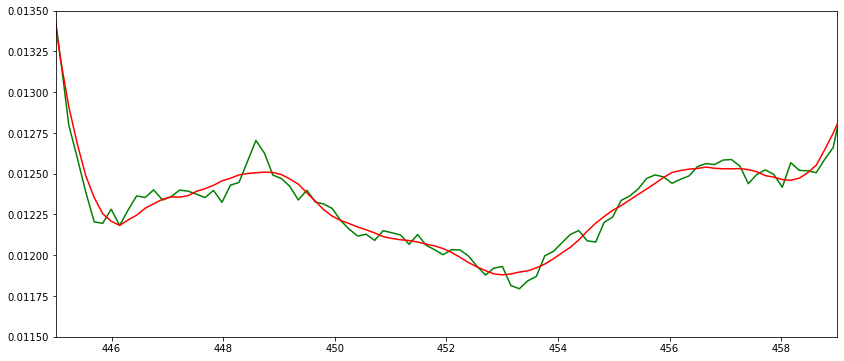

In [332]:
f_c=(I_ratio-1)/70-NO2ref[:,1]*1.325e15
f_c_sg=scs.savgol_filter(f_c, 19, 3)

f, ax1 = plt.subplots(figsize=(14,6))

ax1.plot(line[:,0]*.95+22.95, f_c,'-g',label="")
ax1.plot(line[:,0]*.95+22.95, f_c_sg,'-r',label="")
#-NO2ref[:,1]*1.5e15
ax1.set_xlim(445,459)
#ax1.set_xticks(np.arange(445,460,1))
ax1.set_ylim(0.0115,0.0135)
#ax1.set_xticks(np.arange(440,466,2))
#ax1.set_xlabel('Wavelength',size=14)
#ax1.set_ylabel('Extinction (cm$^{-1}$)',size=14)
#ax1.set_title("CEAS: Extinction v. NO2 reference",size=16)
#ax1.legend(fontsize=12, loc='upper left')
#ax1.tick_params(labelsize=12)
#props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
#ax1.text(0.05, 0.95, 'N=9E10 molecule*$cm^{-3}$ (~4ppb)\n c=5.15E-7', transform=ax0.transAxes, fontsize=14,verticalalignment='top', bbox=props)
#plt.savefig('BBCEASext_v_ref.png')

(442.0, 463.0)

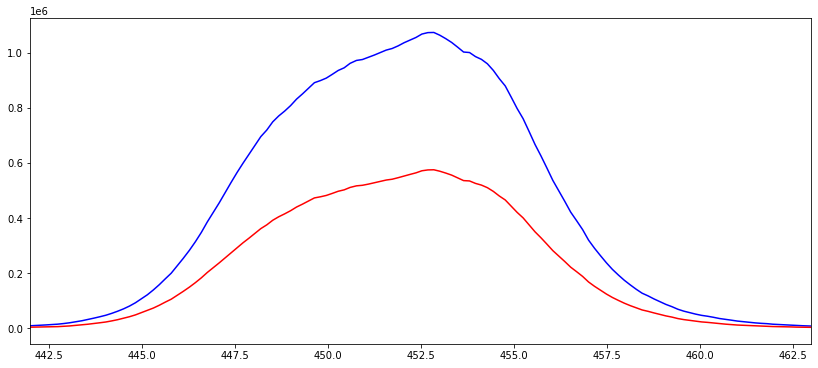

In [75]:
f, ax1 = plt.subplots(figsize=(14,6))

ax1.plot(bckg[:,0], bckg[:,1],'-b',label="")
ax1.plot(line[:,0], line[:,1],'-r',label="")

ax1.set_xlim(442,463)
#ax1.set_xticks(np.arange(446,459,1))
#ax1.set_ylim(0,2e5)
#ax1.set_xticks(np.arange(440,466,2))
#ax1.set_xlabel('Wavelength',size=14)
#ax1.set_ylabel('Extinction (cm$^{-1}$)',size=14)
#ax1.set_title("CEAS: Extinction v. NO2 reference",size=16)
#ax1.legend(fontsize=12, loc='upper left')
#ax1.tick_params(labelsize=12)
#props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
#ax1.text(0.05, 0.95, 'N=9E10 molecule*$cm^{-3}$ (~4ppb)\n c=5.15E-7', transform=ax0.transAxes, fontsize=14,verticalalignment='top', bbox=props)
#plt.savefig('BBCEASext_v_ref.png')

In [30]:
Reff

array([1.00001531, 1.00000783, 0.99999382, ..., 0.99999587, 0.99999568,
       0.99999967])

In [92]:
no2refa=np.load("NO2.npy")
wave=line[:,0]*.95+22.95
inter=np.interp(wave,no2refa[:,0],no2refa[:,1])

wavel=np.copy(wave).reshape(len(wave),1)
interp=np.copy(inter).reshape(len(inter),1)

no2=np.concatenate((wavel,interp),axis=1)

(442.0, 463.0)

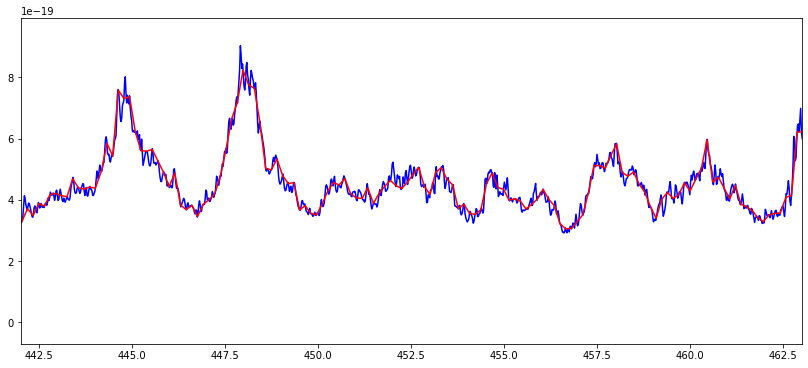

In [117]:
f, ax1 = plt.subplots(figsize=(14,6))

ax1.plot(no2refa[:,0],no2refa[:,1],'-b',label="")
ax1.plot(no2[:,0], no2[:,1],'-r',label="")

ax1.set_xlim(442,463)
#ax1.set_xticks(np.arange(446,459,1))
#ax1.set_ylim(0,2e5)
#ax1.set_xticks(np.arange(440,466,2))
#ax1.set_xlabel('Wavelength',size=14)
#ax1.set_ylabel('Extinction (cm$^{-1}$)',size=14)
#ax1.set_title("CEAS: Extinction v. NO2 reference",size=16)
#ax1.legend(fontsize=12, loc='upper left')
#ax1.tick_params(labelsize=12)
#props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
#ax1.text(0.05, 0.95, 'N=9E10 molecule*$cm^{-3}$ (~4ppb)\n c=5.15E-7', transform=ax0.transAxes, fontsize=14,verticalalignment='top', bbox=props)
#plt.savefig('BBCEASext_v_ref.png')

In [93]:
print(wave.shape,inter.shape,wavel.shape,interp.shape,no2.shape)

(3647,) (3647,) (3647, 1) (3647, 1) (3647, 2)


In [94]:
np.save("NO2ref_AvSC_corr",no2)

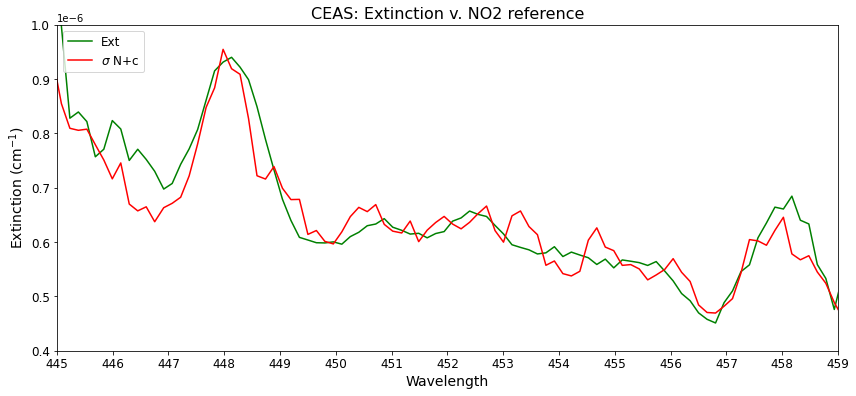

In [310]:
f, ax1 = plt.subplots(figsize=(14,6))

ax1.plot(SCln1[:,0]*.95+22.95, alpha2,'-g',label="Ext")
ax1.plot(NO2ref[:,0], NO2ref[:,1]*7.0e11-.000000014*NO2ref[:,0]+6.65e-6,'-r',label="$\sigma$ N+c")

ax1.set_xlim(445,459)
ax1.set_xticks(np.arange(445,460,1))
ax1.set_ylim(4e-7,1.0e-6)
#ax1.set_xticks(np.arange(440,466,2))
ax1.set_xlabel('Wavelength',size=14)
ax1.set_ylabel('Extinction (cm$^{-1}$)',size=14)
ax1.set_title("CEAS: Extinction v. NO2 reference",size=16)
ax1.legend(fontsize=12, loc='upper left')
ax1.tick_params(labelsize=12)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
#ax1.text(0.05, 0.95, 'N=9E10 molecule*$cm^{-3}$ (~4ppb)\n c=5.15E-7', transform=ax0.transAxes, fontsize=14,verticalalignment='top', bbox=props)
#plt.savefig('BBCEASext_v_ref.png')

In [418]:
ext=np.copy(alpha2).reshape(len(alpha2),1)
print(ext.shape, NO2ref.shape)
ones = np.ones((len(alpha2),1))
ref = np.copy(NO2ref)
print(ones.shape)
svdmat=np.concatenate((ones,ref),axis=1)
print(svdmat.shape)

(3647, 1) (3647, 2)
(3647, 1)
(3647, 3)


In [419]:
U, S, Vt = np.linalg.svd(svdmat,full_matrices=False)
x_hat = Vt.T @ np.linalg.inv(np.diag(S)) @ U.T @ ext
print(x_hat,x_hat.shape)

[[-1.20534126e-06]
 [-5.17831283e-10]
 [ 6.25240230e+11]] (3, 1)


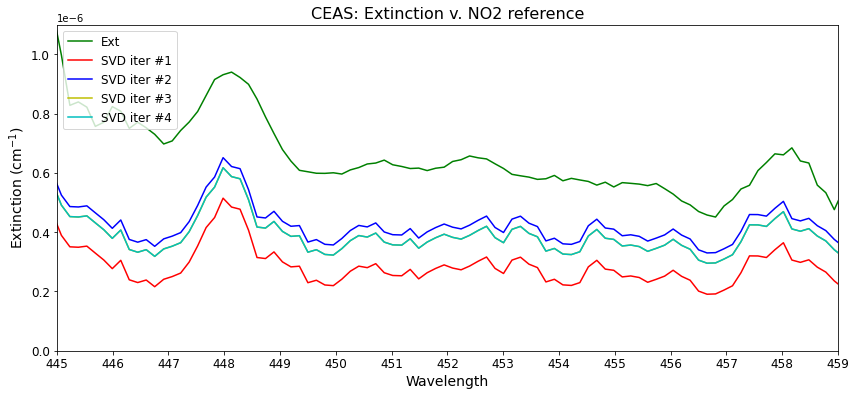

In [420]:
f, ax1 = plt.subplots(figsize=(14,6))

ax1.plot(SCln1[:,0]*.95+22.95, alpha2,'-g',label="Ext")
ax1.plot(NO2ref[:,0], x_hat[2,0]*ref[:,1]+x_hat[1,0]*ref[:,0]*x_hat[0,0],'-r',label="SVD iter #1")

ones=ones*x_hat[0,0]
ref[:,0]=ref[:,0]*x_hat[1,0]
ref[:,1]=ref[:,1]*x_hat[2,0]
svdmat=np.concatenate((ones,ref),axis=1)
U, S, Vt = np.linalg.svd(svdmat,full_matrices=False)
x_hat = Vt.T @ np.linalg.inv(np.diag(S)) @ U.T @ ext

ax1.plot(NO2ref[:,0], x_hat[2,0]*ref[:,1]+x_hat[1,0]*ref[:,0]*x_hat[0,0],'-b',label="SVD iter #2")


ones=ones*x_hat[0,0]
ref[:,0]=ref[:,0]*x_hat[1,0]
ref[:,1]=ref[:,1]*x_hat[2,0]
svdmat=np.concatenate((ones,ref),axis=1)
U, S, Vt = np.linalg.svd(svdmat,full_matrices=False)
x_hat = Vt.T @ np.linalg.inv(np.diag(S)) @ U.T @ ext

ax1.plot(NO2ref[:,0], x_hat[2,0]*ref[:,1]+x_hat[1,0]*ref[:,0]*x_hat[0,0],'-y',label="SVD iter #3")

ones=ones*x_hat[0,0]
ref[:,0]=ref[:,0]*x_hat[1,0]
ref[:,1]=ref[:,1]*x_hat[2,0]
svdmat=np.concatenate((ones,ref),axis=1)
U, S, Vt = np.linalg.svd(svdmat,full_matrices=False)
x_hat = Vt.T @ np.linalg.inv(np.diag(S)) @ U.T @ ext

ax1.plot(NO2ref[:,0], x_hat[2,0]*ref[:,1]+x_hat[1,0]*ref[:,0]*x_hat[0,0],'-c',label="SVD iter #4")

ax1.set_xlim(445,459)
ax1.set_xticks(np.arange(445,460,1))
ax1.set_ylim(0e-7,1.1e-6)
#ax1.set_xticks(np.arange(440,466,2))
ax1.set_xlabel('Wavelength',size=14)
ax1.set_ylabel('Extinction (cm$^{-1}$)',size=14)
ax1.set_title("CEAS: Extinction v. NO2 reference",size=16)
ax1.legend(fontsize=12, loc='upper left')
ax1.tick_params(labelsize=12)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
#ax1.text(0.05, 0.95, 'N=9E10 molecule*$cm^{-3}$ (~4ppb)\n c=5.15E-7', transform=ax0.transAxes, fontsize=14,verticalalignment='top', bbox=props)
#plt.savefig('BBCEASext_v_ref.png')